# Clean pipeline from png to alarm - Single image 

In [8]:
import numpy as np
import cv2
import pydicom as dicom
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema

## The image in this example

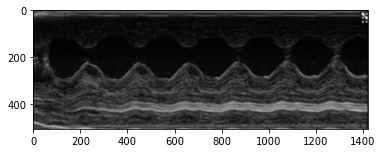

In [3]:
img = cv2.imread("small_test_image.png", 0)
implot = plt.imshow(img, cmap="gray")

### Functions for finding IVS, LVAW, LVID and LVPW distances

In [4]:
# Link: https://www.geeksforgeeks.org/longest-sequence-positive-integers-array/

def getLongestSeq_LVID(a, n):
    maxIdx = 0
    maxLen = 0
    currLen = 0
    currIdx = 0
    for k in range(n):
        if a[k] < 15:
            currLen += 1
            if currLen == 1:
                currIdx = k
        else:
            if currLen > maxLen:
                maxLen = currLen
                maxIdx = currIdx
            currLen = 0
 
    if currLen > maxLen:
        maxLen = currLen
        maxIdx = currIdx
 
    if maxLen > 0:
        return maxIdx, maxLen
    else:
        return 0,0 

def getLongestSeq_below_LVPW(a, n):
    maxIdx = 0
    maxLen = 0
    currLen = 0
    currIdx = 0
    for k in range(n):
        if a[k] > 100:
            currLen += 1
            if currLen == 1:
                currIdx = k
        else:
            if currLen > maxLen:
                maxLen = currLen
                maxIdx = currIdx
            currLen = 0
 
    if currLen > maxLen:
        maxLen = currLen
        maxIdx = currIdx
 
    if maxLen > 0:
        return maxIdx, maxLen
    else:
        return 0,0

### Finding measurements

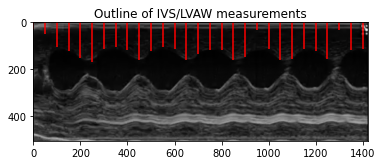

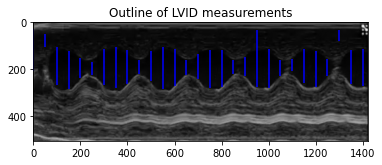

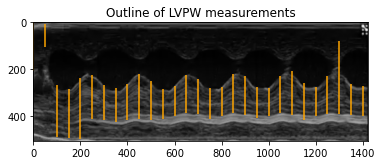

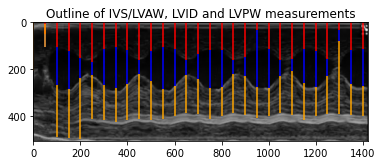

In [14]:
# LVPW Goes from start_below_LVPW_x to end_LVID_y
# IVS goes from start_LVID_x to top of frame at 0

start_LVID_x = []
end_LVID_y = []
start_below_LVPW_x = []
end_below_LVPW_y = []

for i in range(len(img[0])):
    col = img[:,i]
    n_ = len(col)
    
    start_LVID,stretch_LVID = getLongestSeq_LVID(col, n_)
    
    start_LVID_x.append(start_LVID)
    end_LVID_y.append(start_LVID+stretch_LVID)

    start_LVPW,stretch_LVPW = getLongestSeq_below_LVPW(col, n_)
    
    start_below_LVPW_x.append(start_LVPW)
    end_below_LVPW_y.append(start_LVPW+stretch_LVPW)

# Saving the measurements 
IVS_LVAW = np.array(start_LVID_x)
LVID = np.array(end_LVID_y) - np.array(start_LVID_x)  
LVPW = np.array(start_below_LVPW_x) - np.array(end_LVID_y)


plt.imshow(img, cmap="gray")
for i in range(0,len(start_LVID_x),50):
    #IVS/LVAW
    plt.vlines(i, start_LVID_x[i], 0, colors="red")
plt.title("Outline of IVS/LVAW measurements")
plt.show()

plt.imshow(img, cmap="gray")
for i in range(0,len(start_LVID_x),50):
    #LVID
    plt.vlines(i, start_LVID_x[i], end_LVID_y[i], colors="blue")
plt.title("Outline of LVID measurements")
plt.show()

plt.imshow(img, cmap="gray")
for i in range(0,len(start_LVID_x),50):
    #LVPW
    plt.vlines(i, start_below_LVPW_x[i], end_LVID_y[i], colors="orange")
plt.title("Outline of LVPW measurements")
plt.show()

plt.imshow(img, cmap="gray")
for i in range(0,len(start_LVID_x),50):
    #IVS/LVAW
    plt.vlines(i, start_LVID_x[i], 0, colors="red")
    #LVID
    plt.vlines(i, start_LVID_x[i], end_LVID_y[i], colors="blue")
    #LVPW
    plt.vlines(i, start_below_LVPW_x[i], end_LVID_y[i], colors="orange")
plt.title("Outline of IVS/LVAW, LVID and LVPW measurements")
plt.show()

## Diastole and systole measurements

### Functions

In [6]:
# Link: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int((window_len-1)/2):-int((window_len-1)/2)]

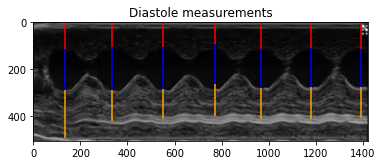

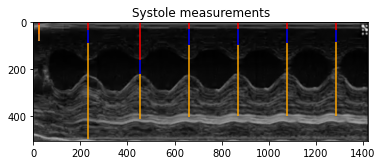

In [9]:

LVID_diastole = []
LVID_systole = []

IVS_LVAW_diastole = []
IVS_LVAW_systole = []

LVPW_diastole = []
LVPW_systole = []

LVID_smooth = smooth(LVID,155,"blackman")

### Diastole
plt.imshow(img, cmap="gray")
for i in list(argrelextrema(LVID_smooth, np.greater)[0]):
    # Saving the values
    LVID_diastole.append(end_LVID_y[i]-start_LVID_x[i])
    IVS_LVAW_diastole.append(start_LVID_x[i])
    LVPW_diastole.append(start_below_LVPW_x[i] - end_LVID_y[i])

    #IVS/LVAW
    plt.vlines(i, start_LVID_x[i], 0, colors="red")
    #LVID
    plt.vlines(i, start_LVID_x[i], end_LVID_y[i], colors="blue")
    #LVPW
    plt.vlines(i, start_below_LVPW_x[i], end_LVID_y[i], colors="orange")
    plt.title("Diastole measurements")
plt.show()


### Systole
plt.imshow(img, cmap="gray")
for i in list(argrelextrema(LVID_smooth, np.less)[0]):
    # Saving the values
    LVID_systole.append(end_LVID_y[i]-start_LVID_x[i])
    IVS_LVAW_systole.append(start_LVID_x[i])
    LVPW_systole.append(start_below_LVPW_x[i] - end_LVID_y[i])

    #IVS/LVAW
    plt.vlines(i, start_LVID_x[i], 0, colors="red")
    #LVID
    plt.vlines(i, start_LVID_x[i], end_LVID_y[i], colors="blue")
    #LVPW
    plt.vlines(i, start_below_LVPW_x[i], end_LVID_y[i], colors="orange")
    plt.title("Systole measurements")

plt.show()

## Inferring length of walls from scale

In [10]:
# The scale in the image goes from 2.8 to 10.9 so the whole scale is:
full_length = 10.9-2.8

# We divide this by the number of pixels in a column,
# so we can convert from pixel stretch to actual measurement
one_pixel_length = full_length/len(img[:,0])


# Actual measurements of IVS/LVAW, LVID and LVPW
LVID_diastole_real = np.array(LVID_diastole)  * one_pixel_length 
LVID_systole_real = np.array(LVID_systole) * one_pixel_length

IVS_LVAW_diastole_real = np.array(IVS_LVAW_diastole) * one_pixel_length
IVS_LVAW_systole_real = np.array(IVS_LVAW_systole) * one_pixel_length

LVPW_diastole_real = np.array(LVPW_diastole) * one_pixel_length
LVPW_systole_real = np.array(LVPW_systole) * one_pixel_length


# Average measurements
LVID_d = np.mean(LVID_diastole_real)
LVID_s = np.mean(LVID_systole_real)

IVS_LVAW_d = np.mean(IVS_LVAW_diastole_real)
IVS_LVAW_s = np.mean(IVS_LVAW_systole_real)

LVPW_d = np.mean(LVPW_diastole_real)
LVPW_s = np.mean(LVPW_systole_real)

### Calculating parameters

In [12]:
LVESV = (7/(2.4+LVID_s))*LVID_s**3
LVEDV = (7/(2.4+LVID_d))*LVID_d**3

FS = ((LVID_d - LVID_s)/LVID_d)*100
EF = ((LVEDV-LVESV)/LVEDV)*100

SV = LVEDV - LVESV
CO = SV*450   

# Only for SAX images
LV_mass = 1.04*(((LVID_d+IVS_LVAW_d+LVPW_d)**3)-(LVID_d**3))*0.8+0.6

## Checking values against normal range

In [13]:
count = 0

if LVESV < 19.35-11.3 or LVESV > 19.35+11.3:
    count += 1
if LVEDV < 57.7-16.5 or LVEDV > 57.7+16.5:
    count += 1
if FS < 43-9 or FS > 43+9:
    count += 1
if EF < 71-11 or EF > 71+11:
    count += 1
if SV < 35.1-8.5 or SV > 35.1+8.5:
    count += 1
if CO < 17.7-3.8 or CO > 17.7+3.8:
    count += 1
if LV_mass < 96-18 or LV_mass > 96+18:
    count +=1
# OBS there is no measurement for RWT, so I don't know why we calculate it

if count >= 3:
    print("ALARM! This mouse has a sick heart!")
    print("This heart presents {} abnormal values.".format(count))

ALARM! This mouse has a sick heart!
This heart presents 6 abnormal values.
